# Analysis: Posteriors and Dynamical times

## 1. Develop the de-bias technique
## 2. Measure dynamical times in the MW halo

In [4]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize
from exptool.basis import spheresl
from exptool.basis import eof

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# read in the posteriors.

def read_posterior(pfile):
    
    A = np.genfromtxt(pfile)
    
    dname = {}
    dname['vtravel'] = A[:,0]
    dname['phi'] = (180./np.pi)*A[:,1]
    dname['phi'][dname['phi']<0.] += 360.
    dname['theta'] = 90.-(180./np.pi)*np.arccos(A[:,2])
    dname['sigmar'] = 1./np.sqrt(A[:,3])
    dname['sigmap'] = 1./np.sqrt(A[:,4])
    dname['sigmat'] = 1./np.sqrt(A[:,5])
    dname['vra'] = A[:,6]
    dname['vth'] = A[:,7]
    dname['vphi'] = A[:,8]
    
    return dname



# BHBs with different distance cuts
#BHB = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/BHBs_d035150_sgr20_L3000.posterior')
BHB = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/BHBs_d050150_sgr20_L3000.posterior')

# K giants with different distance cuts
KGiants = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/KGiants_d050150_sgr20_L3000.posterior')
#KGiants = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/KGiants_d035150_sgr20_L3000.posterior')

# satellites
SAT = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/sats.posterior')

# cohen 2017 RRL
#RRL = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/RRL_d050150.posterior')

# globular clusters
GC = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/GCs_d008.posterior')
#GC = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/GCs_d025.posterior')

# Hobson+ 00 weighted K giants and BHBs only
ALL = read_posterior('/Users/mpetersen/Dropbox/mike/data/all_average_d050150_sgr20_L3000.posterior')


cats = ['vtravel','phi','theta','sigmar','sigmap','sigmat','vra','vth','vphi']
dictnames = [ALL,BHB,KGiants,SAT,GC]

def total_bounds(dictnames,cats):
    
    bounddict = {}
    
    for cat in cats:
        bounddict[cat] = [np.percentile(np.array(np.concatenate([dictname[cat] for dictname in dictnames])),0.2),\
                          np.percentile(np.array(np.concatenate([dictname[cat] for dictname in dictnames])),99.8)]

    return bounddict

bounddict = total_bounds(dictnames,cats)

    

In [12]:
import reflexmotion.reflex as rm


def norm_histogram(arr,bins=-1):
    
    if bins == -1:
        bins = int(len(arr)/100.)
        
    a = np.percentile(arr,0.0)
    A = np.percentile(arr,99.9)
    binvals = np.linspace(a,A,bins)
    outvals = np.zeros(binvals.size)
    #print(a,A,bins)
    da = (A-a)/(bins)
    
    for val in arr:
        #print(val-a,(val-a)/(da))
        indx = (val-a)/da
        if indx>bins-1: indx=bins-1
        #print(indx)
        outvals[int(indx)] += 1
        
    return binvals,outvals/(len(arr)*(A-a)/(bins-1))

 


In [15]:
#l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=0.,pointres=180,reverse=False,twopi=True,travel='u',flip=False,verbose=False)

# leo 1
#226.15 49.26
# 280.47,-32.89 

l,b,dist,vlos,mul,mub = rm.make_debias_model(226.15,49.26,ALL['phi'],ALL['theta'],ALL['vtravel'],psi=0.,verbose=False)

l,b,dist,vlos,mul,mub = rm.make_debias_model(-(280.47-180.),-32.89,ALL['phi'],ALL['theta'],ALL['vtravel'],psi=0.,verbose=False)




-17.6
17.2
15.2


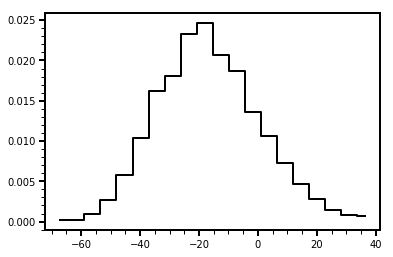

In [16]:
#plt.scatter(vlos,mul)
print(np.round(np.nanpercentile(vlos,50.),1))
print(np.round(np.nanpercentile(vlos,84.)-np.nanpercentile(vlos,50.),1))
print(np.round(np.nanpercentile(vlos,50.)-np.nanpercentile(vlos,16.),1))



A,B = norm_histogram(vlos,bins=20)
plt.plot(A,B,color='black',linestyle='steps-mid')
  

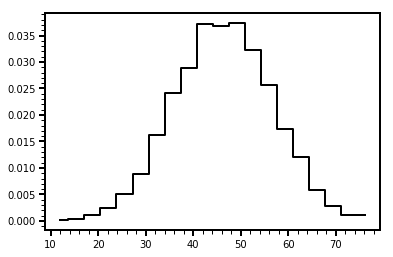

In [17]:
A,B = norm_histogram(ALL['vtravel'],bins=20)
plt.plot(A,B,color='black',linestyle='steps-mid')
  

In [18]:
print(90.-np.nanpercentile(ALL['theta'],50))

112.76072247741651


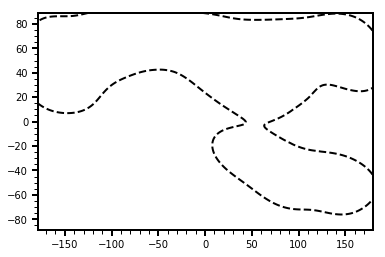

In [22]:
from exptool.utils import kde_3d

X11 = np.genfromtxt('data/Xue2011BHB.txt',\
                        dtype={'names': ("RA","Dec","Glon","Glat",\
                                         "gmag","ug","gr","D0.2","fm",\
                                         "cHg","bHg","d","r",\
                                         "x","y","z","HRV",\
                                         "eHRV","Vgal","DR8","Sloan",\
                                         "SimbadName"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'S20')},\
                 skip_header=77,delimiter=';')



bhbl = X11['Glon']
bhbl[bhbl > 180.] -= 360.


bhbb = X11['Glat']

xx,yy,bhbw = kde_3d.total_kde_two(bhbl,-bhbb,\
                                       gridsize=256,\
                                       extents=(-179,179.,-89,89),\
                                       #extents=(0.,360.,-90,90),\
                                       #weights=PSPDump.mass/np.cos(halob),\
                                       ktype='gaussian',npower=6.)


plt.contour(xx,yy,np.log10(bhbw),[-5.],colors='black')

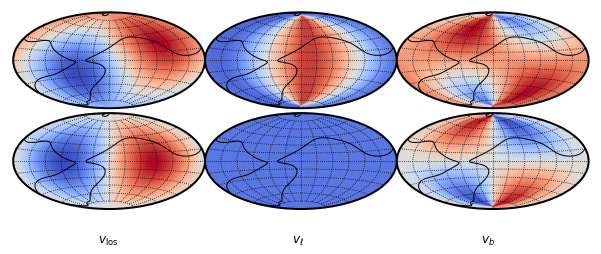

In [23]:
velstretch = np.linspace(-32,32,64)

# set up model 2

phi = np.nanpercentile(ALL['phi'],50)
theta = 120.#90.-np.nanpercentile(ALL['theta'],50)


psi = 0.

twopi=False
travel='u'
#phi = 285.;theta=145.;psi=0.
#phi = 0.;theta=90.;psi=0.

pointres=50



fig = plt.figure(figsize=(8,4))
#ax = plt.subplot(111, projection="aitoff")
ax1 = fig.add_axes([0.0,0.55,0.333,0.35], projection="aitoff")
ax2 = fig.add_axes([0.333,0.55,0.333,0.35], projection="aitoff")
ax3 = fig.add_axes([0.666,0.55,0.333,0.35], projection="aitoff")
ax4 = fig.add_axes([0.0,0.2,0.333,0.35], projection="aitoff")
ax5 = fig.add_axes([0.333,0.2,0.333,0.35], projection="aitoff")
ax6 = fig.add_axes([0.666,0.2,0.333,0.35], projection="aitoff")

l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)
vel = vlos
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax1.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = rm.undo_proper_motion(mul,dist)
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax2.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = rm.undo_proper_motion(mub,dist)
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax3.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

phi = 90.#np.nanpercentile(ALL['phi'],50)
theta = 90.#90.-np.nanpercentile(ALL['theta'],50)


l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)
vel = vlos
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax4.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = -np.ones(mul.size)*0.8#rm.undo_proper_motion(mul,dist)*0. + 1.
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax5.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = rm.undo_proper_motion(mub,dist)
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax6.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)




for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.grid(True,color='black',linestyle='dotted')
    ax.set_xticklabels(())
    ax.set_yticklabels(())
    #xx[xx>180.]-=360.
    ax.contour(-(np.pi/180.)*xx,(np.pi/180.)*yy,-np.log10(bhbw),[5.],colors='black',linewidths=1.)

plt.text(0.33/2.,0.1,'$v_{\\rm los}$',size=12,transform=fig.transFigure,ha='center',va='center')
plt.text(0.33/2.+0.33,0.1,'$v_{\ell}$',size=12,transform=fig.transFigure,ha='center',va='center')
plt.text(0.33/2.+0.66,0.1,'$v_{b}$',size=12,transform=fig.transFigure,ha='center',va='center')


plt.savefig('figures/model_values.png',dpi=300)

In [47]:
np.nanmax(l)

6.283185307179586

In [49]:
phi = np.nanpercentile(ALL['phi'],50)
theta = 120.#90.-np.nanpercentile(ALL['theta'],50)
l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)



lflat = b[l<np.pi].reshape(-1,)
lorder = lflat.argsort()

lflat = lflat[lorder]

vflat = 1000.*dk*mub[l<np.pi].reshape(-1,)[lorder]


lbins = 90
nl = int(np.floor(lflat.size/lbins))
lavg = np.zeros(lbins)
lvavg = np.zeros(lbins)
lvmin = np.zeros(lbins)
lvmax = np.zeros(lbins)


f = open('processed/model_b_values_pi.txt','w')


for i in range(0,lbins):
    lavg[i] = np.nanmean(lflat[i*nl:(i+1)*nl])
    lvavg[i] = np.nanmean(vflat[i*nl:(i+1)*nl])
    lvmin[i] = np.nanmin(vflat[i*nl:(i+1)*nl])
    lvmax[i] = np.nanmax(vflat[i*nl:(i+1)*nl])
    print(lavg[i],lvavg[i],lvmin[i],lvmax[i],file=f)
    
f.close()

lflat = b[l>np.pi].reshape(-1,)
lorder = lflat.argsort()

lflat = lflat[lorder]

vflat = 1000.*dk*mub[l>np.pi].reshape(-1,)[lorder]


lbins = 90
nl = int(np.floor(lflat.size/lbins))
lavg = np.zeros(lbins)
lvavg = np.zeros(lbins)
lvmin = np.zeros(lbins)
lvmax = np.zeros(lbins)


f = open('processed/model_b_values_2pi.txt','w')


for i in range(0,lbins):
    lavg[i] = np.nanmean(lflat[i*nl:(i+1)*nl])
    lvavg[i] = np.nanmean(vflat[i*nl:(i+1)*nl])
    lvmin[i] = np.nanmin(vflat[i*nl:(i+1)*nl])
    lvmax[i] = np.nanmax(vflat[i*nl:(i+1)*nl])
    print(lavg[i],lvavg[i],lvmin[i],lvmax[i],file=f)
    
f.close()




lflat = l.reshape(-1,)
lorder = lflat.argsort()

lflat = lflat[lorder]

vflat = 1000.*dk*mul.reshape(-1,)[lorder]


lbins = 45
nl = int(np.floor(lflat.size/lbins))
lavg = np.zeros(lbins)
lvavg = np.zeros(lbins)
lvmin = np.zeros(lbins)
lvmax = np.zeros(lbins)


f = open('processed/model_l_values.txt','w')


for i in range(0,lbins):
    lavg[i] = np.nanmean(lflat[i*nl:(i+1)*nl])
    lvavg[i] = np.nanmean(vflat[i*nl:(i+1)*nl])
    lvmin[i] = np.nanmin(vflat[i*nl:(i+1)*nl])
    lvmax[i] = np.nanmax(vflat[i*nl:(i+1)*nl])
    print(lavg[i],lvavg[i],lvmin[i],lvmax[i],file=f)
    
f.close()




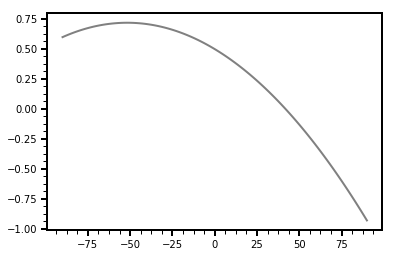

In [57]:
bmodel = np.genfromtxt('processed/model_b_values_2pi.txt')

pp = np.polyfit((180./np.pi)*bmodel[:,0],1.3*bmodel[:,1]-0.2,2)
pfit = np.poly1d(pp)
plt.plot(np.linspace(-90.,90.,100),pfit(np.linspace(-90.,90.,100)),linestyle='solid',lw=2.,color='grey',zorder=-10)



## Part 2: Dynamical Times in the MW halo

In [83]:

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy import interpolate as interpolate

from exptool.analysis import commensurability



class spherical_model(object):
    rcurve = 0
    potcurve = 0
    dpotcurve = 0



def find_j(r,kappa,model):
    dudr = model.dpotcurve(r)#model.dpotcurve[ (abs(r-model.rcurve)).argmin()]
    jmax = np.sqrt(r*r*r*dudr);
    J = jmax*kappa;
    return J

#plt.plot(model.rcurve,find_jmax(model.rcurve,1.,model))



#// Function to iteratively locate radius of circular orbit with energy EE 
def Ecirc(r,E,model):
    ur = model.potcurve(r)#model.potcurve[ (abs(r-model.rcurve)).argmin()]
    dudr = model.dpotcurve(r)#model.dpotcurve[ (abs(r-model.rcurve)).argmin()]
    return  E - 0.5*r*dudr - ur

  
def denom(r,E,J,model):
    ur = model.potcurve(r)#model.potcurve[ (abs(r-model.rcurve)).argmin()]
    return 2.0*(E-ur)*r*r - J*J;


class orbit(object):
  r_circ = 0.
  r_apo = 0.
  r_peri = 0.
  ee = 0.
  jj = 0.
  kappa = 0.
  


def make_orbit(orbit,E,K,model):
  orbit.ee = E
  #
  # this should work, the boundaries are in radius...
  orbit.r_circ = brentq(Ecirc,np.min(model.rcurve),np.max(model.rcurve),args=(orbit.ee,model))
  orbit.kappa = K
  orbit.jj = find_j(orbit.r_circ,orbit.kappa,model)
  orbit.r_apo = brentq(denom,orbit.r_circ,np.max(model.rcurve),args=(orbit.ee,orbit.jj,model))
  orbit.r_peri = brentq(denom,np.min(model.rcurve),orbit.r_circ,args=(orbit.ee,orbit.jj,model))
  return orbit




def compute_frequencies(orbit,model):
  ap = 0.5*(orbit.r_apo + orbit.r_peri);
  am = 0.5*(orbit.r_apo - orbit.r_peri);
  sp = ap/(orbit.r_apo*orbit.r_peri);
  sm = am/(orbit.r_apo*orbit.r_peri);
  #
  accum0 = 0.0;
  accum1 = 0.0;
  accum2 = 0.0;
  #
  FRECS = 16
  #
  dt = np.pi/FRECS;
  #
  # the 'centered rectangle technique'
  #
  t = 0.5*(dt-np.pi)
  for i in range(0,FRECS):
      #
      r = ap + am*np.sin(t)
      #
      ur = model.potcurve(r)#model.potcurve[ (abs(r-model.rcurve)).argmin()]
      cost = np.cos(t)
      #t +=
      #
      tmp = np.sqrt(2.0*(orbit.ee-ur) - (orbit.jj*orbit.jj)/(r*r));
      accum0 += cost * tmp;
      accum1 += cost / tmp;
      s = sp + sm*np.sin(t);
      ur = model.potcurve(1.0/s)#model.potcurve[ (abs( (1.0/s)-model.rcurve)).argmin()]
      accum2 += cost/np.sqrt(2.0*(orbit.ee-ur) - (orbit.jj*orbit.jj*s*s));
      t += dt
  #
  #
  orbit.freq = np.zeros(3)
  orbit.action = np.zeros(3)
  #    
  orbit.freq[0] = np.pi/(am*accum1*dt);
  orbit.freq[1] = orbit.freq[0]*orbit.jj * sm*accum2*dt/np.pi;
  orbit.freq[2] = 0.0;
  #
  orbit.action[0] = am*accum0*dt/np.pi;
  orbit.action[1] = orbit.jj;
  orbit.action[2] = 0.0;
  return orbit




def make_sph_model_file(filename,twopower=True):
    #
    if twopower:
        M = np.loadtxt(filename, dtype={'names': ('rcurve', 'dcurve', 'mcurve','potcurve'),'formats': ('f4', 'f4', 'f4','f4')},skiprows=1)
    else:
        M = np.loadtxt(filename, dtype={'names': ('rcurve', 'potcurve', 'dpotcurve'),'formats': ('f4', 'f4', 'f4')},skiprows=1)
    #
    model = spherical_model()
    model.rcurve = M['rcurve'][3000:]
    potcurve = M['potcurve'][3000:]
    model.potcurve = UnivariateSpline(model.rcurve,potcurve,s=0)
    model.dpotcurve = UnivariateSpline(model.rcurve,potcurve,s=0).derivative()
    #model.dpotcurve = UnivariateSpline(M['rcurve'],M['potcurve']).derivative()
    #
    #model.rcurve = M['rcurve']    
    #
    #model.potcurve = UnivariateSpline(model.rcurve,M['potcurve'],s=0)
    #model.dpotcurve = UnivariateSpline(model.rcurve,M['dpotcurve'],k=2)
    #
    #model.potcurve =  interp1d(model.rcurve,M['potcurve'],kind='cubic')
    #model.dpotcurve =  interp1d(model.rcurve,M['dpotcurve'],kind='cubic')
    #
    #model.potcurve =  interp1d(model.rcurve,M['potcurve'])
    #model.dpotcurve =  interp1d(model.rcurve,M['dpotcurve'])
    #
    #
    return model



def make_sph_model(PotInstance,rads=np.linspace(0.,0.1,100)):
    model = spherical_model()
    PotInstance.compute_axis_potential(rvals=rads)
    #
    model.rcurve = PotInstance.rvals
    model.potcurve = interp1d(PotInstance.rvals,PotInstance.total_pot)
    model.dpotcurve = interp1d(PotInstance.rvals,PotInstance.total_dpdr)
    #
    return model



def find_resonance(Rres,Tres,Pres,OMEGA,model):
    krange = np.linspace(0.01,0.995,50)
    erange = np.zeros_like(krange)
    for index,value in enumerate(krange):
        # check the boundary values        
        try:
            #print(brentq(locate,0.99*model.potcurve(np.min(model.rcurve)),model.potcurve(0.99*np.max(model.rcurve)),args=(kappa,0,2,2,patt,model)))
            erange[index] = brentq(locate,0.99*model.potcurve(np.min(model.rcurve)),model.potcurve(0.99*np.max(model.rcurve)),args=(value,Rres,Tres,Pres,OMEGA,model))
        except:
            pass
    #print(erange)
    gvals = np.where( (erange > model.potcurve(np.min(model.rcurve))) & (erange < model.potcurve(np.max(model.rcurve))) & (erange != 0.) )[0]  
    return krange[gvals],erange[gvals]



def locate(E,K,L1,L2,MM,OMEGA,model):
  O = orbit()
  O = make_orbit(O,E,K,model)
  O = compute_frequencies(O,model)
  return O.freq[0]*L1 + O.freq[1]*L2 - OMEGA*MM;




def make_resonance_model(PotInstance,\
                         rads=np.linspace(0.,0.06,50),\
                         vels=np.linspace(0.0,1.5,50)):
    #
    #
    rr,vv = np.meshgrid(rads,vels)
    PotInstance.disk_use_m = 0
    PotInstance.halo_use_l = 0
    PotInstance.rotation_curve(rvals=rads)
    PotInstance.compute_axis_potential(rvals=rads)
    #
    model = make_sph_model(PotInstance,rads=rads)
    #
    tp = np.tile(model.potcurve(rads),(vels.size,1))
    tv = np.tile((rads*model.dpotcurve(rads))**0.5,(vels.size,1))
    ee = 0.5*vv*vv + tp
    kk = (vv)/(tv)
    #
    kk[kk>1.] = 1.
    kk[kk<-1.] = -1.
    #
    #
    model.rfunc = interpolate.interp2d(ee,kk,rr,kind='cubic')
    model.vfunc = interpolate.interp2d(ee,kk,vv,kind='cubic')
    return model




[106.48577541  63.59417396   0.        ]
[111.34501141  56.8011989    0.        ]


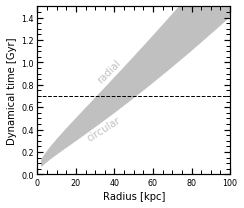

In [232]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
    
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True



model = make_sph_model_file('SLGridSph.mw')

O = orbit()
#ee = -6.
#O.r_circ = brentq(Ecirc,np.min(model.rcurve),np.max(model.rcurve),args=(ee,model))
#print(O.r_circ)
O = make_orbit(O,-7.,0.9999,model)
O = compute_frequencies(O,model)

print(O.freq)

O = make_orbit(O,-7.,0.04,model)
O = compute_frequencies(O,model)

print(O.freq)

erange = np.linspace(0.95*np.nanmin(model.potcurve(model.rcurve)),1.1*np.nanmax(model.potcurve(model.rcurve)),100)

rfunc = UnivariateSpline(model.potcurve(model.rcurve),model.rcurve,s=0)
rrange = rfunc(erange)
frcirc = np.zeros(erange.size)
fpcirc = np.zeros(erange.size)
frrad = np.zeros(erange.size)
fprad = np.zeros(erange.size)

for ie,ee in enumerate(erange):
    #print(ee)
    # circular first
    O = make_orbit(O,ee,0.99,model)
    O = compute_frequencies(O,model)
    frcirc[ie] = O.freq[0]
    fpcirc[ie] = O.freq[1]
    
    # radial
    O = make_orbit(O,ee,.1,model)
    O = compute_frequencies(O,model)
    frrad[ie] = O.freq[0]
    fprad[ie] = O.freq[1]


#plt.plot(300.*rrange,2.2*(2.*np.pi)/fpcirc,color='black')
#plt.plot(300.*rrange,2.2*(2.*np.pi)/frrad,color='gray')

fig = plt.figure(figsize=(3.5,3))
ax = fig.add_subplot(111)

infalltime = 0.7
ax.fill_between(300.*rrange,(2.2*(2.*np.pi)/frrad),(2.2*(2.*np.pi)/fpcirc),color='silver')


ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="both",which='both',direction="in")



#ax.plot([0.,150.],[0.7,0.7],color='black',linestyle='dashed')
ax.plot([0.,150.],[0.7,0.7],color='black',linestyle='dashed',lw=1.)

ax.text(30.,0.8,'radial',color='silver',size=10,rotation=45,ha='left',va='bottom')
ax.text(25.,0.53,'circular',color='silver',size=10,rotation=32,ha='left',va='top')




ax.set_xlabel('Radius [kpc]',size=10)
ax.set_ylabel('Dynamical time [Gyr]',size=10)
#ax.set_yticks([0.,0.5,1.,1.5,2.])

ax.axis([0.,100.,0.,1.5])
fig.tight_layout()
plt.savefig('/Users/mpetersen/Dropbox/mike/Models_15May/dynamical_time_estimates_new.png',dpi=300)

[106.48577541  63.59417396   0.        ]
[111.34501141  56.8011989    0.        ]


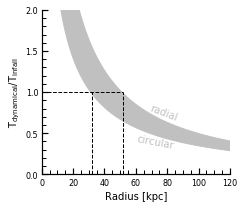

In [233]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
    
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



model = make_sph_model_file('SLGridSph.mw')

O = orbit()
#ee = -6.
#O.r_circ = brentq(Ecirc,np.min(model.rcurve),np.max(model.rcurve),args=(ee,model))
#print(O.r_circ)
O = make_orbit(O,-7.,0.9999,model)
O = compute_frequencies(O,model)

print(O.freq)

O = make_orbit(O,-7.,0.04,model)
O = compute_frequencies(O,model)

print(O.freq)

erange = np.linspace(0.95*np.nanmin(model.potcurve(model.rcurve)),1.1*np.nanmax(model.potcurve(model.rcurve)),100)

rfunc = UnivariateSpline(model.potcurve(model.rcurve),model.rcurve,s=0)
rrange = rfunc(erange)
frcirc = np.zeros(erange.size)
fpcirc = np.zeros(erange.size)
frrad = np.zeros(erange.size)
fprad = np.zeros(erange.size)

for ie,ee in enumerate(erange):
    #print(ee)
    # circular first
    O = make_orbit(O,ee,0.99,model)
    O = compute_frequencies(O,model)
    frcirc[ie] = O.freq[0]
    fpcirc[ie] = O.freq[1]
    
    # radial
    O = make_orbit(O,ee,.1,model)
    O = compute_frequencies(O,model)
    frrad[ie] = O.freq[0]
    fprad[ie] = O.freq[1]


#plt.plot(300.*rrange,2.2*(2.*np.pi)/fpcirc,color='black')
#plt.plot(300.*rrange,2.2*(2.*np.pi)/frrad,color='gray')

fig = plt.figure(figsize=(3.5,3))
ax = fig.add_subplot(111)

infalltime = 0.7
ax.fill_between(300.*rrange,infalltime/(2.2*(2.*np.pi)/frrad),infalltime/(2.2*(2.*np.pi)/fpcirc),color='silver')

ax.text(68.,0.63,'radial',color='silver',size=10,rotation=-21,ha='left',va='bottom')
ax.text(60.,0.5,'circular',color='silver',size=10,rotation=-11,ha='left',va='top')

ax.tick_params(axis="both",which='both',direction="in")



#ax.plot([0.,150.],[0.7,0.7],color='black',linestyle='dashed')
ax.plot([0.,51.5],[1.0,1.0],color='black',linestyle='dashed',lw=1.)
ax.plot([51.5,51.5],[0.0,1.0],color='black',linestyle='dashed',lw=1.)
ax.plot([32.,32.],[0.0,1.0],color='black',linestyle='dashed',lw=1.)




ax.set_xlabel('Radius [kpc]',size=10)
ax.set_ylabel('${\\rm T}_{\\rm dynamical}/{\\rm T}_{\\rm infall}$',size=10)
ax.set_yticks([0.,0.5,1.,1.5,2.])

ax.axis([0.,120.,0.,2.])
fig.tight_layout()
plt.savefig('/Users/mpetersen/Dropbox/mike/Models_15May/dynamical_time_estimates.png',dpi=300)

## Part 3: Softening in the model

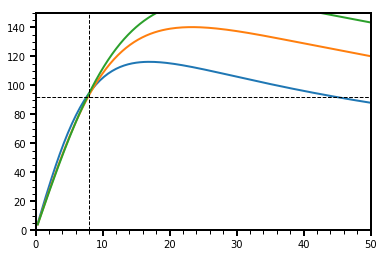

In [87]:
# try first in virial

def plummer_circ(core,satmass,rtest=np.linspace(0.001,1.0,1000)):

    fac = rtest*rtest + core*core
    fac = np.power(fac, -0.5)
    ffac = -satmass*fac*fac*fac
    rforce = ffac*(rtest)
    vcirc = np.sqrt(rtest*-rforce)
    
    return rtest,vcirc


dscale = 300.
vscale = 220./1.45
mscale = 1./16.4
core = 0.04 
satmass = 1.*mscale


rtest,vcirc = plummer_circ(core,satmass)
plt.plot(dscale*rtest,vscale*vcirc)

core = 0.055 
satmass = 2.*mscale
rtest,vcirc = plummer_circ(core,satmass)
plt.plot(dscale*rtest,vscale*vcirc)

core = 0.064 
satmass = 3.*mscale
rtest,vcirc = plummer_circ(core,satmass)
plt.plot(dscale*rtest,vscale*vcirc)


plt.axis([0.,50.,0.,150.])

plt.plot([0.,100.],[92.,92.],color='black',lw=1.,linestyle='dashed')
plt.plot([8.,8.],[0.,150.],color='black',lw=1.,linestyle='dashed')



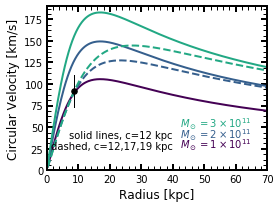

In [118]:
# try first in virial

fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot(111)

dscale = 300.
vscale = 200./1.45
mscale = 1./16.4

core = 0.04 
satmass = 1.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.0,1.))

core = 0.04
satmass = 2.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.3,1.))

core = 0.055
satmass = 2.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.3,1.),linestyle='dashed')

core = 0.04 
satmass = 3.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.6,1.))

core = 0.064 
satmass = 3.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.6,1.),linestyle='dashed')



ax.axis([0.,70.,0.,190.])

# lines
ax.scatter([8.7],[91.7],color='black',s=30.,zorder=10)
ax.plot([8.7,8.7],[91.7-18.8,91.7+18.8],color='black',lw=1.)

ax.set_xlabel('Radius [kpc]',size=12)
ax.set_ylabel('Circular Velocity [km/s]',size=12)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="both",which='both',direction="in")


ax.text(65.,50.,'$M_\odot=3\\times10^{11}$',color=cm.viridis(0.6,1.),ha='right')
ax.text(65.,37.5,'$M_\odot=2\\times10^{11}$',color=cm.viridis(0.3,1.),ha='right')
ax.text(65.,25.,'$M_\odot=1\\times10^{11}$',color=cm.viridis(0.0,1.),ha='right')

ax.text(40.,37.5,'solid lines, c=12 kpc',color='black',ha='right')
ax.text(40.,25.,'dashed, c=12,17,19 kpc',color='black',ha='right')



plt.tight_layout()
plt.savefig('figures/LMC_model_comparison.png',dpi=300)


In [116]:

# from the trajectory file
tlmc, xlmc, ylmc, zlmc  = 0.0,    12.78, -39.22, -28.01
tlmc2,xlmc2,ylmc2,zlmc2 = 0.0044, 12.23, -40.26, -26.88

vxlmc = (xlmc2-xlmc)/tlmc2
vylmc = (ylmc2-ylmc)/tlmc2
vzlmc = (zlmc2-zlmc)/tlmc2

llmc = np.arctan2(ylmc,xlmc)
blmc = np.arccos(zlmc/np.sqrt(xlmc*xlmc+ylmc*ylmc+zlmc*zlmc))
print((180./np.pi)*llmc,90.-(180./np.pi)*blmc)
print(vxlmc,vylmc,vzlmc)

# true LMC
# 080.8942 -69.7561

-71.95158537710576 -34.17789406303237
-124.99999999999974 -236.36363636363615 256.8181818181824
